In [1]:
import pickle
import pandas as pd

# 데이터 읽어오기
df = pd.read_pickle('path_df.pkl')
exploit=df
exploit

,EID,PATH_NUM,SYSCALL_PATH
0,10613,exit_code,"[102, 1]"
1,10613,exit_code,"[102, 1, 12, 12, 1, 59]"
2,10613,exit_code,"[102, 1]"
3,10613,exit_code,"[102, 1, 12, 12, 1, 59]"
4,10613,main,"[102, 104, 1, 117, 119, 9, 9, 9, 9, 11]"
...,...,...,...
4076,9545,main,"[102, 104, 9, 41]"
4077,9545,main,"[102, 104, 9, 41, 87, 77, 40, 59]"
4078,9545,main,"[102, 104, 9]"
4079,9575,main,"[41, inet_addr, htons, 9, 46, 46, 3, 13, 13, 1..."


In [2]:
# syscall path만 뽑아서 이차원 데이터로 만들기
tokened_syscall_path = [syscall for syscall in df['SYSCALL_PATH']]
tokened_syscall_path[:10]

[['102', '1'],
 ['102', '1', '12', '12', '1', '59'],
 ['102', '1'],
 ['102', '1', '12', '12', '1', '59'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11'],
 ['102',
  '104',
  '1',
  '117',
  '119',
  '9',
  '9',
  '9',
  '9',
  '11',
  '22',
  '3',
  '13',
  '278'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11', '22'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11'],
 ['102',
  '104',
  '1',
  '117',
  '119',
  '9',
  '9',
  '9',
  '9',
  '11',
  '22',
  '3',
  '13',
  '278'],
 ['102', '104', '1', '117', '119', '9', '9', '9', '9', '11', '22']]

In [3]:
dictionary = set()
not_syscall = set()
all =set()
for path in tokened_syscall_path:
    for syscall in path:
        all.add(syscall)
        if str.isdigit(syscall):
            dictionary.add(syscall)
        else:
            if "setns" == syscall:
                dictionary.add("setns")
            if "time" == syscall:
                dictionary.add("time")
            if "capset" == syscall:
                dictionary.add("capset")
            if "fstat" == syscall:
                dictionary.add("fstat")
            if "__NR_vm86old" == syscall:
                dictionary.add("__NR_vm86old")
            else:
                not_syscall.add(syscall)
        
print(len(dictionary))
print(len(all))

137
317


### Word2Vec의 평균을 사용한 Syscall Sequence Embedding
파라미터 의미 참고: https://hoonzi-text.tistory.com/2

In [4]:
# 모든 path 시퀀스 Word2Vec 훈련시키기
from gensim.models import Word2Vec

word2vec_model = Word2Vec(tokened_syscall_path, size=4, window=2, min_count=1, sg=1)

In [5]:
import numpy as np
# 각 exploit에 존재하는 system call들의 vector 값의 평균을 구하여 해당 exploit code의 vector값을 구함
def get_exploit_vectors(document_list):
    document_embedding_list = []

    # 각 Exploit에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line:
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 Exploit에 있는 모든 syscall들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # syscall 벡터를 모두 더한 벡터의 값을 Exploit 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)
        else:
            document_embedding_list.append(np.zeros(100))

    # 각 Exploit에 대한 Exploit 벡터 리스트를 리턴
    return document_embedding_list

In [6]:
exploit_embedding_list = get_exploit_vectors(exploit['SYSCALL_PATH'])
print('문서 벡터의 수 :',len(exploit_embedding_list))

/tmp/ipykernel_2390435/2519065890.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = word2vec_model[word]
/tmp/ipykernel_2390435/2519065890.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc2vec = doc2vec + word2vec_model[word]


문서 벡터의 수 : 4081


0.10886212410200316


<Figure size 500x500 with 0 Axes>

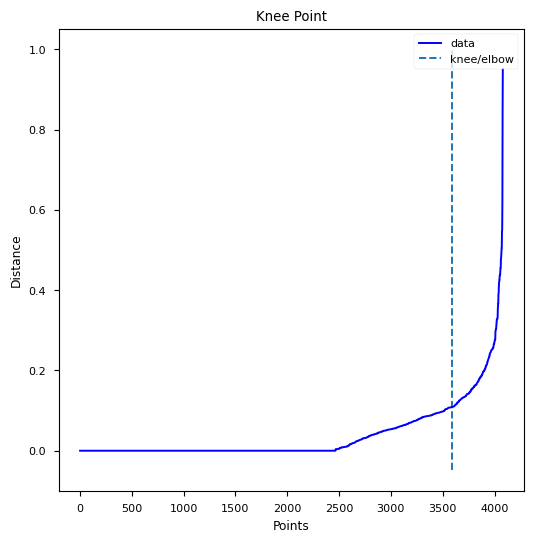

In [60]:
# EPS(Epsilon) 값을 결정하기 위한 가장 가까운 neighbor 거리 계산
n_neighbors = 3
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors = nearest_neighbors.fit(exploit_embedding_list)
distances, indices = neighbors.kneighbors(exploit_embedding_list)
distances = np.sort(distances[:,n_neighbors-1], axis=0)

#elbow point를 detect하는 API
from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
plt.style.use("seaborn-paper")
knee.plot_knee()
plt.title("Knee Point")
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
import numpy as np

# 문서를 명사 집합으로 보고 문서 리스트로 치환 (tfidfVectorizer 인풋 형태를 맞추기 위해)
text = [" ".join(syscall) for syscall in df['SYSCALL_PATH']]

model = DBSCAN(eps=0.0005,min_samples=2, metric = "cosine")
# 거리 계산 식으로는 Cosine distance를 이용
result = model.fit_predict(exploit_embedding_list)
df["dbscan_cluster"] = result
df.head()

,EID,PATH_NUM,SYSCALL_PATH,km_label,dbscan_cluster
0,10613,exit_code,"[102, 1]",9,0
1,10613,exit_code,"[102, 1, 12, 12, 1, 59]",48,1
2,10613,exit_code,"[102, 1]",9,0
3,10613,exit_code,"[102, 1, 12, 12, 1, 59]",48,1
4,10613,main,"[102, 104, 1, 117, 119, 9, 9, 9, 9, 11]",31,2


In [46]:
cluster_result = dict()
for cluster_num in set(result):
    # -1,0은 노이즈 판별이 났거나 클러스터링이 안된 경우
    if(cluster_num == -1 or cluster_num == 0): 
        continue
    else:
        cluster_result[cluster_num] = set()
        print("cluster num : {}".format(cluster_num))
        temp_df = df[df['dbscan_cluster'] == cluster_num] # cluster num 별로 조회
        for path in temp_df['EID']:
            print(path)
            cluster_result[cluster_num].add(path)
        print()

cluster num : 1
10613
10613

cluster num : 2
10613
10613

cluster num : 3
10613
10613
42887
42887

cluster num : 4
10613
10613

cluster num : 5
12
12
12
12
12
12
47163
47163
47163
47163
50541
50541
50541
50541

cluster num : 6
12
12
1397
1397
1397
1397
44302
44302

cluster num : 7
12
12
12
12

cluster num : 8
12
12

cluster num : 9
12
12

cluster num : 10
12
12
12
12
33824
33824

cluster num : 11
1397
1397
1397
1397
1397
1397
1397
1397
1397
1397
25202
25202
25202
25202
25202
25202

cluster num : 12
1397
1397

cluster num : 13
1397
1397
1397
1397
1397
1397
25202
25202
25202
25202
25202
25202

cluster num : 14
1397
1397
1397
1397
1397
1397
25202
25202
25202
25202
25202
25202

cluster num : 15
1397
1397
1397
1397

cluster num : 16
1397
1397
47170
47170

cluster num : 17
1397
1397
47163
47163

cluster num : 18
1397
1397
1397
1397

cluster num : 19
1397
1397

cluster num : 20
1397
1397
15024
15024
35370
35370

cluster num : 21
1397
1397

cluster num : 22
1397
1397

cluster num : 23
1397
139

17787
17787

cluster num : 107
17787
17787
17787
17787
17787
17787
17787
17787

cluster num : 108
18411
18411
45553
45553

cluster num : 109
18411
18411

cluster num : 110
18411
18411

cluster num : 111
18411
18411

cluster num : 112
18411
18411

cluster num : 113
18411
18411

cluster num : 114
18411
18411

cluster num : 115
18411
18411
47169
47169
47170
47170

cluster num : 116
18411
18411
33321
33321
35161
35161
35161
35161
9479
9479

cluster num : 117
18411
18411

cluster num : 118
18411
18411

cluster num : 119
18411
18411

cluster num : 120
19419
2005
2005

cluster num : 121
20000
20000

cluster num : 122
20000
20000

cluster num : 123
2004
2006

cluster num : 124
2005
2005
33321
33321
41458
41458
41994
41994
43418
43418

cluster num : 125
2005
2005
2005
2005

cluster num : 126
2005
2005

cluster num : 127
2005
2005

cluster num : 128
2005
2005
47170
47170

cluster num : 129
2005
2005

cluster num : 130
2005
2005
2005
2005

cluster num : 131
2005
2005

cluster num : 132
2005
2005


40871
40871

cluster num : 353
40871
40871

cluster num : 354
40871
40871
40871
40871

cluster num : 355
40871
40871

cluster num : 356
40871
40871

cluster num : 357
40871
40871

cluster num : 358
41458
41458

cluster num : 359
41458
41458
9083
9083

cluster num : 360
41458
41458

cluster num : 361
41458
41458
41458
41458
9083
9083

cluster num : 362
41458
41458
41458
41458
41458
41458
41458
41458

cluster num : 363
41458
41458
41458
41458

cluster num : 364
41458
41458

cluster num : 365
41458
41458

cluster num : 366
41458
41458
41458
41458

cluster num : 367
41458
41458

cluster num : 368
41458
41458
41458
41458

cluster num : 369
41458
41458
41458
41458

cluster num : 370
41458
41458
41994
41994

cluster num : 371
41458
41458
41458
41458
41994
41994
41994
41994
43418
43418
43418
43418
47168
47168
47168
47168
47169
47169
47169
47169

cluster num : 372
41458
41458
41994
41994
47168
47168

cluster num : 373
41458
41458
41994
41994

cluster num : 374
41458
41458
41994
41994
43418
4341

895
895

cluster num : 513
895
895

cluster num : 514
895
895

cluster num : 515
895
895

cluster num : 516
895
895

cluster num : 517
895
895

cluster num : 518
895
895

cluster num : 519
895
895

cluster num : 520
895
895

cluster num : 521
895
895

cluster num : 522
895
895

cluster num : 523
9083
9083

cluster num : 524
9083
9083

cluster num : 525
9083
9083

cluster num : 526
9083
9083

cluster num : 527
9083
9083

cluster num : 528
9083
9083

cluster num : 529
9083
9083

cluster num : 530
9083
9083

cluster num : 531
9083
9083

cluster num : 532
9083
9083

cluster num : 533
9083
9083
9083
9083

cluster num : 534
9083
9083
926
926

cluster num : 535
9083
9083

cluster num : 536
9083
9083

cluster num : 537
9083
9083

cluster num : 538
9083
9083

cluster num : 539
9083
9083
9083
9083

cluster num : 540
9083
9083
926
926

cluster num : 541
9083
9083

cluster num : 542
9083
9083

cluster num : 543
9083
9083

cluster num : 544
9083
9083

cluster num : 545
9083
9083

cluster num : 546


Text(0.5, 1.0, 'PCA Transformed')

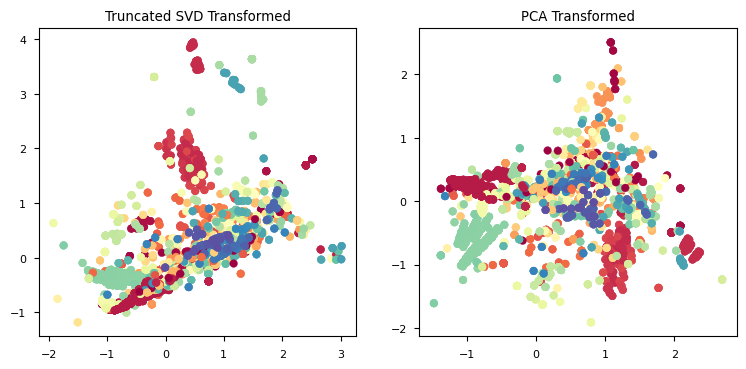

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD, PCA


# 특이값 분해
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(exploit_embedding_list)
scaler = StandardScaler() # exploit 데이터를 StandardScaler로 변환
exploit_tsvd = scaler.fit_transform(exploit_embedding_list)

# 스케일링된 데이터를 기반으로 PCA 변환 수행 
pca = PCA(n_components=2)
pca.fit(exploit_embedding_list)
exploit_pca = pca.transform(exploit_embedding_list)

# TruncatedSVD 변환 데이터를 왼쪽에, PCA변환 데이터를 오른쪽에 표현 
fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
ax1.scatter(x=exploit_tsvd[:,0], y= exploit_tsvd[:,1], c= exploit.dbscan_cluster, cmap='Spectral')
ax2.scatter(x=exploit_pca[:,0], y= exploit_pca[:,1], c= exploit.dbscan_cluster, cmap='Spectral')
ax1.set_title('Truncated SVD Transformed')
ax2.set_title('PCA Transformed')

In [48]:
pca = PCA(n_components=3)
components = pca.fit_transform(exploit_embedding_list)

total_var = pca.explained_variance_ratio_.sum() * 100
import plotly.express as px
fig = px.colors.qualitative.swatches()
fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=exploit.dbscan_cluster,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    color_discrete_sequence=px.colors.qualitative.Dark24
)
fig.show()